In [123]:
#run this to import
try:
    import dill
except:
    %pip install dill
    import dill
dill.load_session('best.db')

# Pneumonia Recognition

## Imports 

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transform
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torchvision.transforms import ToTensor
import glob
from tqdm import tqdm
from matplotlib.pyplot import imshow
from torch.autograd import Variable

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")
print(device)

cuda:0


## Clean Data

In [6]:
train = []
for i in glob.glob("/home/aralegre/PneumoniaRecognition/data/train/NORMAL/*.jpeg"):
    
    train.append([i, 0])
    
for i in glob.glob("/home/aralegre/PneumoniaRecognition/data/train/PNEUMONIA/*.jpeg"):
    
    train.append([i, 1])

trainloader = torch.utils.data.DataLoader(train, batch_size=4, shuffle=True)


test = []
for i in glob.glob("/home/aralegre/PneumoniaRecognition/data/test/NORMAL/*.jpeg"):
    
    test.append([i, 0])
    
for i in glob.glob("/home/aralegre/PneumoniaRecognition/data/test/PNEUMONIA/*.jpeg"):
    
    test.append([i, 1])
    
testloader = torch.utils.data.DataLoader(test, batch_size=4, shuffle=True)

validation = [] 
for i in glob.glob("/home/aralegre/PneumoniaRecognition/data/val/NORMAL/*.jpeg"):
    
    validation.append([i, 0])
    
for i in glob.glob("/home/aralegre/PneumoniaRecognition/data/val/PNEUMONIA/*.jpeg"):
    
    validation.append([i, 1])

tensor([[[[0.1608, 0.1686, 0.1843,  ..., 0.3843, 0.3176, 0.2980],
          [0.1608, 0.1686, 0.1765,  ..., 0.3490, 0.3843, 0.3490],
          [0.1608, 0.1608, 0.1647,  ..., 0.3333, 0.3529, 0.3686],
          ...,
          [0.0863, 0.0784, 0.0510,  ..., 0.1176, 0.1216, 0.1412],
          [0.0863, 0.0745, 0.0353,  ..., 0.1333, 0.1333, 0.1412],
          [0.0863, 0.0745, 0.0353,  ..., 0.1294, 0.1490, 0.1569]],

         [[0.1608, 0.1686, 0.1843,  ..., 0.3843, 0.3176, 0.2980],
          [0.1608, 0.1686, 0.1765,  ..., 0.3490, 0.3843, 0.3490],
          [0.1608, 0.1608, 0.1647,  ..., 0.3333, 0.3529, 0.3686],
          ...,
          [0.0863, 0.0784, 0.0510,  ..., 0.1176, 0.1216, 0.1412],
          [0.0863, 0.0745, 0.0353,  ..., 0.1333, 0.1333, 0.1412],
          [0.0863, 0.0745, 0.0353,  ..., 0.1294, 0.1490, 0.1569]],

         [[0.1608, 0.1686, 0.1843,  ..., 0.3843, 0.3176, 0.2980],
          [0.1608, 0.1686, 0.1765,  ..., 0.3490, 0.3843, 0.3490],
          [0.1608, 0.1608, 0.1647,  ..., 0

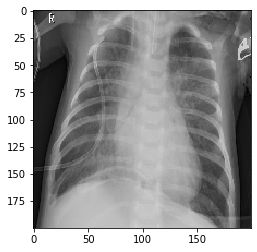

In [7]:
inputs = Image.open(test[-1][0]).convert('RGB')
inputs = inputs.resize((200, 200))
imshow(np.asarray(inputs))
inputs = ToTensor()(inputs).unsqueeze(1).permute(1, 0, 2, 3)
inputs

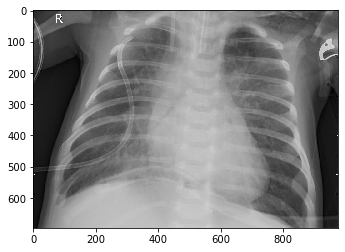

In [8]:
inputs = Image.open(test[-1][0]).convert('RGB')
imshow(np.asarray(inputs))

## Neural Network Defenition

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.conv4 = nn.Conv2d(128, 128, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.drop = nn.Dropout()
        self.linear1 = nn.Linear(12800, 512) 
        nn.init.xavier_uniform_(self.linear1.weight)
        self.linear2 = nn.Linear(512, 1)
        nn.init.xavier_uniform_(self.linear2.weight)
        self.activate = nn.Sigmoid()
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.drop(x.view(-1, 12800))
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        x = self.activate(x)
        return x
net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.5, inplace=False)
  (linear1): Linear(in_features=12800, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=1, bias=True)
  (activate): Sigmoid()
)

## Training

In [7]:
loss_func = nn.BCELoss()
opt = optim.Adam(net.parameters(), lr=0.0003)

In [8]:
def train_accuracy():
    correct = 0
    
    for i in range(len(train)):
        
        inputs = Image.open(train[i][0]).convert('RGB')
        inputs = inputs.resize((200, 200))
        inputs = ToTensor()(inputs).unsqueeze(1).permute(1, 0, 2, 3)
        inputs = inputs.to(device)
        
        prediction = float(net(inputs)[0])
        if((prediction >= .5 and train[i][1] == 1) or (prediction < .5 and train[i][1] == 0)):
        
            correct += 1
        
    return correct/len(train)

def test_accuracy():
    correct = 0
    for i in range(len(test)):
        inputs = Image.open(test[i][0]).convert('RGB')
        inputs = inputs.resize((200, 200))
        inputs = ToTensor()(inputs).unsqueeze(1).permute(1, 0, 2, 3)
        inputs = inputs.to(device)
        
        prediction = float(net(inputs)[0])
        if((prediction >= .5 and test[i][1] == 1) or (prediction < .5 and test[i][1] == 0)):
        
            correct += 1
        
    return correct/len(test)

def val_accuracy():
    correct = 0
    for i in range(len(validation)):
        inputs = Image.open(validation[i][0]).convert('RGB')
        inputs = inputs.resize((200, 200))
        inputs = ToTensor()(inputs).unsqueeze(1).permute(1, 0, 2, 3)
        inputs = inputs.to(device)
        
        prediction = float(net(inputs)[0])
        if((prediction >= .5 and validation[i][1] == 1) or (prediction < .5 and validation[i][1] == 0)):
        
            correct += 1
        
    return correct/len(validation)

In [ ]:
avg_losses = []
train_accuracies = []
val_accuracies = []
epochs = 100

for epoch in tqdm(range(epochs)):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
        paths, labels = data
        inputs = torch.empty(0)
        for l in paths:
            temp = Image.open(l).convert('RGB')
            temp = temp.resize((200, 200))
            temp = ToTensor()(temp).unsqueeze(1).permute(1, 0, 2, 3)
            inputs = torch.cat((inputs, temp), 0)
       
        inputs, labels = inputs.to(device), labels.to(device)
        
        
        opt.zero_grad()
        outputs = net.forward(inputs).float()
        
        loss = loss_func(outputs, labels.float())
        loss.backward()
        opt.step()
        running_loss += loss.item()
       
    avg_losses.append(running_loss / (len(train) / 4))
    train_accuracies.append(train_accuracy())
    val_accuracies.append(val_accuracy())

  0%|          | 0/100 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
 94%|█████████▍| 94/100 [6:15:52<18:05, 180.93s/it]  

## Training Loss

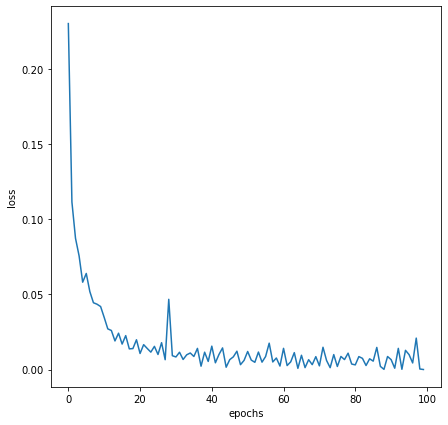

In [125]:
plt.figure(figsize=(7,7))
plt.plot(avg_losses)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

## Train and Validation Accuracies

In [126]:
nums = []
for i in range(1, len(val_accuracies) + 1):
    nums.append(i)

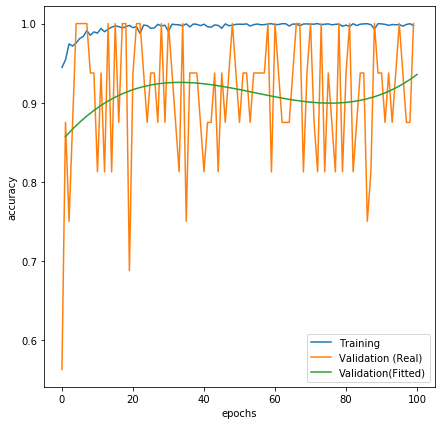

In [127]:
plt.figure(figsize=(7,7))
plt.plot(train_accuracies, label='Training')
plt.plot(val_accuracies, label='Validation (Real)')
#line fit for validation accuracy
z = np.polyfit(nums, val_accuracies, 3)
f = np.poly1d(z)

x_new = np.linspace(nums[0], nums[-1], 50)
y_new = f(x_new)

plt.plot(x_new, y_new, label='Validation(Fitted)')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [23]:
#run this to save
try:
    import dill
except:
    %pip install dill
    import dill
dill.dump_session('.db')